In [22]:
import requests
import base64
import json
import os
import numpy as np
import scipy
import scipy.misc
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import key
import torch
from ultralytics import YOLO

GSV_API_URL = "https://maps.googleapis.com/maps/api/streetview"

class Panorama():

    def __init__(self):
        self.id = "0"
        self.panoid = ""
        self.lon = ""
        self.lat = ""
        self.date = ""
        self.svf = -1.0
        self.tvf = -1.0
        self.bvf = -1.0
        self.initialized = False

    def fromJSON(self, str):
        try:
            root = json.loads(str)
            if root['status'] != "OK":
                return False
            location = root['location']
            self.date = root['date']
            self.panoid = root['pano_id']
            self.lat = location['lat']
            self.lon = location['lng']
            self.initialized = True
            return True
        except ValueError:
            return False
        return False

    def fromLocation(self, lat, lon):
        url = GSV_API_URL + "/metadata?location=" + \
            str(lat) + "," + str(lon) + "&key=" + key.apikey

        try:
            response = requests.get(url)
            if response.status_code == requests.codes.ok:
                return self.fromJSON(response.content)
        except ValueError:
            return False
        return False

    def toString(self):
        return str(self.id) + "," + self.panoid + "," + self.date + "," + str(self.lat) + "," + str(self.lon) + "," + str(self.svf) + "," + str(self.tvf) + "," + str(self.bvf)


class GSVCapture():
    def __init__(self):
        # Initialize necessary attributes
        self.input_shape = (3, 512, 512)

    def checkDir(self, dir):
        if not (dir.endswith('/') or dir.endswith('\\')):
            dir = dir + '/'
        return dir

    def getImage(self, panoId, x, y, zoom, outdir):
        url = "https://" + "geo0.ggpht.com/cbk?cb_client=maps_sv.tactile&authuser=0&hl=en&panoid=" + \
            panoId + "&output=tile&x=" + \
            str(x) + "&y=" + str(y) + "&zoom=" + str(zoom) + "&nbt&fover=2"
        outfile = outdir + "/" + str(x) + "_" + str(y) + ".jpg"
        try:
            response = requests.get(url)
            if response.status_code == requests.codes.ok:
                file = BytesIO(response.content)
                return file
        except ValueError:
            return None
        return None

    def equirectangular2fisheye(self, infile, outfile):
        img = Image.open(infile)
        width, height = img.size
        img = img.crop((0, 0, width, height // 2))
        width, height = img.size
        red, green, blue = img.split()
        red = np.asarray(red)
        green = np.asarray(green)
        blue = np.asarray(blue)
        fisheye = np.ndarray(shape=(512, 512, 3), dtype=np.uint8)
        fisheye.fill(0)
        x = np.arange(0, 512, dtype=float)
        x = x / 511.0
        x = (x - 0.5) * 2
        x = np.tile(x, (512, 1))
        y = x.transpose()
        dist2ori = np.sqrt((y * y) + (x * x))

        zenithD = dist2ori * 90.0
        zenithD[np.where(zenithD <= 0.000000001)] = 0.000000001
        zenithR = zenithD * 3.1415926 / 180.0
        x2 = np.ndarray(shape=(512, 512), dtype=float)
        x2.fill(0.0)
        y2 = np.ndarray(shape=(512, 512), dtype=float)
        y2.fill(1.0)
        cosa = (x*x2 + y*y2) / np.sqrt((x*x + y*y) * (x2*x2 + y2*y2))
        lon = np.arccos(cosa) * 180.0 / 3.1415926
        indices = np.where(x > 0)
        lon[indices] = 360.0 - lon[indices]
        lon = 360.0 - lon
        lon = 1.0 - (lon / 360.0)
        outside = np.where(dist2ori > 1)
        lat = dist2ori
        srcx = (lon*(width-1)).astype(int)
        srcy = (lat*(height-1)).astype(int)
        srcy[np.where(srcy > 255)] = 0
        indices = (srcx + srcy*width).tolist()

        red = np.take(red, np.array(indices))
        green = np.take(green, np.array(indices))
        blue = np.take(blue, np.array(indices))
        red[outside] = 0
        green[outside] = 0
        blue[outside] = 0
        fisheye = np.dstack((red, green, blue))
        Image.fromarray(fisheye).save(outfile)
        return [-1, -1, -1]

    def classifyOld(self, infile, outfile):
        bestModelPath = 'best_earn.pt'
        bestModel = YOLO(bestModelPath)

        results = bestModel.predict(source=infile, imgsz=640)
        annotatedImage = results[0].plot()
        annotatedImageRGB = cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB)
        plt.imshow(annotatedImageRGB)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def showMasks(self, results, class_id=2, class_name='tree', ax=None):
        for result in results:
            masks = result.masks.data
            boxes = result.boxes.data

            clss = boxes[:, 5]
            people_indices = torch.where(clss == class_id)
            people_masks = masks[people_indices]
            people_mask = torch.any(people_masks, dim=0).int() * 255

            cnt = people_mask.cpu().numpy()
            count = np.sum(cnt > 0)
            # img_name = 'img/merged_segs'+ str(class_id) +'.jpg'
            # cv2.imwrite(img_name, people_mask.cpu().numpy())
            if ax is not None:
                ax[class_id +1].imshow(people_mask.cpu().numpy(), cmap='gray')
                ax[class_id +1].axis('off')
                ax[class_id +1].set_title(f'{class_name}: {count} px')
                continue

        return {class_name: count}

    def classify(self, infile, outfile):
        modelPath = 'best_earn.pt'
        model = YOLO(modelPath)
        results = model.predict(source=infile, imgsz=640)
        annotatedImage = results[0].plot()
        annotatedImageRGB = cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB)

        res = []
        _, buffer = cv2.imencode('.jpg', annotatedImage)
        img_str = base64.b64encode(buffer).decode('utf-8')
        res.append(img_str)

        names = model.names
        fig, ax = plt.subplots(1, len(names) + 1, figsize=(10, 10))
        ax[0].imshow(annotatedImageRGB)
        ax[0].axis('off')
        
        for n in names:
            segmentCount = self.showMasks(results, n, names[n], ax)
            res.append(segmentCount)

        plt.tight_layout()
        plt.show()  

        return res 

    def countAllPixels(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        count = np.sum(image > 0)
        return count
               
    def getByID(self, outdir, panoid):
        if panoid == '':
            return [-1, -1, -1]
        outdir = self.checkDir(outdir)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        tilesize = 512
        numtilesx = 4
        numtilesy = 2
        mosaicxsize = tilesize*numtilesx
        mosaicysize = tilesize*numtilesy
        mosaic = Image.new("RGB", (mosaicxsize, mosaicysize), "black")
        blkpixels = 0
        for x in range(0, numtilesx):
            for y in range(0, numtilesy):
                imageTile = self.getImage(panoid, x, y, 2, outdir)
                if imageTile == None:
                    return ""
                img = Image.open(imageTile)
                if y == 1:
                    pix_val = list(img.getdata())
                    blk1 = pix_val[tilesize*tilesize-1]
                    blk2 = pix_val[tilesize*(tilesize-1)]
                    blkpixels = blkpixels + sum(blk1) + sum(blk2)
                mosaic.paste(img, (x*tilesize, y*tilesize, x *
                             tilesize+tilesize, y*tilesize+tilesize))
        xstart = (512 - 128) / 2
        xsize = mosaicxsize - xstart * 2
        ysize = mosaicysize - (512 - 320)
        if blkpixels == 0:
            mosaic = mosaic.crop((xstart, 0, xstart+xsize, ysize))
        mosaic = mosaic.resize((1024, 512))
        mosaic.save(outdir + "mosaic.png")
        self.equirectangular2fisheye(
            outdir + "mosaic.png", outdir + "fisheye.png")

        res = self.classify(outdir + "fisheye.png", outdir +
                      "fisheye_classified.png")
        countAllPixels = self.countAllPixels(outdir + "fisheye.png")
        res.append({'all': countAllPixels})

        return res
    
    def getByLatLong(self, outdir, lat, lon):
        pano = Panorama()
        pano.fromLocation(lat, lon)
        if not pano.initialized:
            # print("Not available")
            return ""
        outdir = self.checkDir(outdir)
        outdir = outdir + pano.panoid + '/'
        res = self.getByID(outdir, pano.panoid)

        return res





image 1/1 /Users/sakdahomhuan/Dev/cmu_py499/proj_earn_gsv/img/PaqLaC7ooZmd98GPucpbCA/fisheye.png: 640x640 2 trees, 165.1ms
Speed: 6.4ms preprocess, 165.1ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)


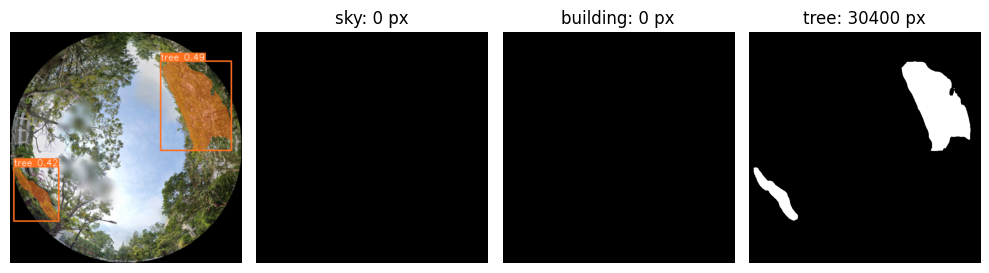

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAIAAgADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD+f+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopVVnYKqkk9AB1rqvBvwP+Kvj6J7jwv4LvbiKO3MxmMRVCoOOGOATkEYHPBqJ1IU1eTsvMEmzlKK9e8PfsxQ2qvc+PPE3kNbndcWVpESdvT/WH7

In [23]:
gsv = GSVCapture()

latLngs = [(18.80322604063747, 98.95020624026014),
              (18.80409042354406, 98.95267978867928),
              (18.804455644749574, 98.95406876396386),
              (18.80707568953787, 98.95735167813076),
              (18.803163718220073, 98.95929370025283),
              (18.802320564480837, 98.96607334366405),
              (18.798533293867514, 98.96677671821367),
              (18.79648724856904, 98.97691060342076),
              (18.795743245954508, 98.98486737617445),
              (18.79406431529187, 98.98737700754616),
              (18.791474013175467, 98.98215720003668),
              (18.789024054151245, 98.9744382313473),
              (18.789431445831408, 98.96876486636566),
              (18.778059272703235, 98.97690323505478)]

latLng = [(18.80322604063747, 98.95020624026014)]
for lat, lon in latLng:
    res = gsv.getByLatLong(outdir='img', lat=lat, lon=lon)
    print(res)
    # gsv.getByLatLong(outdir='img', lat=18.802896778231123, lon=98.95099645493178)

In [ ]:
# Flask API for the above code
from flask import Flask, request
app = Flask(__name__)

@app.route('/getByLatLong', methods=['GET'])
def getByLatLong():
    lat = request.args.get('lat')
    lon = request.args.get('lon')
    gsv.getByLatLong(outdir='img', lat=lat, lon=lon)
    return 'Done'

if __name__ == '__main__':
    app.run(port=5000, debug=True)

# how to call the API
# http://localhost:5000/getByLatLong?lat=18.80322604063747&lon=98.95020624026014
